In [1]:
%pylab inline

import torch
import torchvision
from torch.utils.data import Dataset
from PIL import ImageDraw, Image

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.cuda.current_device()
print(torch.cuda.is_available())
cuda = torch.device('cuda') 

True


In [0]:
cpu = torch.device('cpu')

In [0]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [0]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        for i in range(num_blocks):
            self.add_module('block_{}'.format(i + 1), module=EncoderBlock(in_channels=in_channels, 
                                                                         out_channels=num_filters))
            in_channels = num_filters
            num_filters *= 2
            
        self.mpull = torch.nn.MaxPool2d(2, 2)

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            block = self.__getattr__('block_{}'.format(i + 1))
            
            x = block.forward(x)
            activations.append(x.clone())
            if i != self.num_blocks - 1:
                x = self.mpull(x)
        return activations

In [0]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(out_channels * 2, out_channels, 3, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels * 2, out_channels, 3, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.up = torch.nn.Upsample(scale_factor=2, align_corners=True, mode='bilinear')

    def forward(self, down, left):
        # upscale->conv+relu->concat->conv+relu->conv+relu - make it
        #x = self.up(down)
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = torch.cat([x, left], dim=1)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        return x

In [0]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        for i in range(num_blocks):
            self.add_module('block_{}'.format(num_blocks - i), DecoderBlock(num_filters * 2**(i)))

    def forward(self, activations):
        x = activations[-1]
        for i in range(len(activations) - 2, -1, -1):
            block = self.__getattr__('block_{}'.format(self.num_blocks - i))
            x = block(x, activations[i])
        self.num_outchannels = x.shape[1]
        return x

In [0]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=8, num_blocks=4):
        super().__init__()
        self.encoder =  Encoder(in_channels, num_filters, num_blocks)
        self.decoder =  Decoder(num_filters, num_blocks)
        self.final =  torch.nn.Conv2d(num_filters, num_classes, 1, padding=0)
        self.sigm = torch.nn.Sigmoid()

    def forward(self, x):
        #print(self.decoder)
        #print(self.encoder)
        #print(self.final)
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        x = self.sigm(x)
        return x

In [0]:
class Figures(Dataset):
    def __init__(self, num_images=10, num_figure=10, size_hor=200, size_ver=200,
                 min_size=5, max_size=40, noise=False,
                 normalize=None):
        
        self.images = []
        
        for _ in range(num_images):
            color_background = tuple(np.random.randint(low=0, high=255, size=3))
            image = Image.new(mode='RGB', size=(size_hor, size_ver), color=color_background)
            draw = ImageDraw.Draw(image)

            mask = Image.new(mode='1', size=(size_hor, size_ver), color=0)
            draw_mask = ImageDraw.Draw(mask)
            
            for i in range(num_figure):
                color = tuple(np.random.randint(low=0, high=255, size=3))
                size = np.random.randint(low=min_size, high=max_size)
                
                xl = np.random.randint(low=0, high=size_hor-size)
                yt = np.random.randint(low=0, high=size_ver-size)
                xr = xl + size
                yb = yt + size
                
                figure_type = np.random.choice(['circle', 'triangle', 'rectangle'])
                if figure_type == 'circle':
                    draw.ellipse((xl, yt, xr, yb), fill=color)
                    draw_mask.ellipse((xl, yt, xr, yb), fill=1)
                elif figure_type == 'rectangle':
                    draw.rectangle((xl, yt, xr, yb), fill=color)
                    draw_mask.rectangle((xl, yt, xr, yb), fill=1)
                elif figure_type == 'triangle':
                    draw.polygon((xl, yb, xr, yb, (xl + xr) / 2, yt), fill=color)
                    draw_mask.polygon((xl, yb, xr, yb, (xl + xr) / 2, yt), fill=1)

            image = torchvision.transforms.ToTensor()(image).float()
            mask = torchvision.transforms.ToTensor()(mask).float()
            
            if normalize:
                image = normalize(image)
           
            if noise:
                mean, var = 0, 0.001
                gauss = np.random.normal(mean, var ** 0.5, (3, size_hor, size_ver))
                image = image + torch.FloatTensor(gauss)
                
            self.images.append({'image': image, 'mask': mask})

    def __getitem__(self, index):
        return self.images[index]
        
    def __len__(self):
        return len(self.images)

In [0]:
generator = Figures(noise=True, normalize=None)

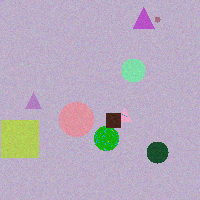

In [11]:
torchvision.transforms.ToPILImage()(generator[0]['image'])

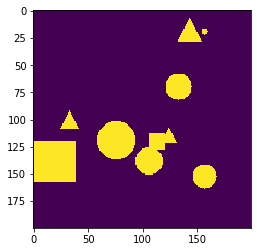

In [12]:
plt.imshow(np.array(generator[0]['mask'][0, :, :]).reshape((200, 200)))
plt.show()

In [0]:
data = Figures(num_images=1000, noise=False)

image_pixels = torch.stack([ell['image'].reshape((3, -1)) for ell in data], dim=1)
mean_ = image_pixels.reshape((3, -1)).mean(1)
std_ = image_pixels.reshape((3, -1)).std(1)
normalize = torchvision.transforms.Normalize(mean_, std_)

In [0]:
def dice_coefficient(mask, prediction):
    # your code
    '''
    inter = (prediction.contiguous().view(-1) * mask.contiguous().view(-1)).sum()
    x = (prediction.contiguous().view(-1) * prediction.contiguous().view(-1)).sum()
    y = (mask.contiguous().view(-1) * mask.contiguous().view(-1)).sum()
    
    return 1. - ((2. * inter + 1.)/(x + y + 1))
    '''
    num = 2. * (torch.sum(prediction * mask)).float()
    denom = (torch.sum(prediction + mask)).float()
    return 1. - (num + 1.) / (denom + 1.)

In [15]:
torch.manual_seed(10)

test_mask = torch.randint(0, 2, size=(8, 1, 300, 300)).float()
prediction_mask = torch.randint(0, 2, size=(8, 1, 300, 300)).float()

dice_coefficient(test_mask, prediction_mask)

tensor(0.4995)

In [0]:
batch_size = 100

train_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=2000),
    batch_size=batch_size, shuffle=True, pin_memory=True)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=200),
    batch_size=batch_size, pin_memory=True)

train_size = len(train_data_loader.dataset)
test_size = len(test_data_loader.dataset)

In [0]:
criterion = torch.nn.BCELoss()
num_epoch = 40

network = UNet(num_classes=1).to(cuda)
optimizer = torch.optim.Adam(network.parameters())

In [18]:
global_step = 0

for epoch in range(num_epoch):
    loss_train = 0
    for i, batch in enumerate(train_data_loader):
        # main train loop: zero gradient, forward, loss, backward, update
        optimizer.zero_grad()
        output = network(batch['image'].to(cuda))
        #print(output.shape, batch['mask'].shape)
        loss = criterion(output.to(cpu), batch['mask'].to(cpu))
        loss_train += batch_size * float(loss.detach())
        loss.backward()
        optimizer.step()
    loss_train = loss_train / train_size
        
    loss_test, dice_test = 0, 0
    for i, batch in enumerate(test_data_loader):
        output = network(batch['image'].to(cuda))
        prediction_mask = (output > 0).float()
        loss_test += batch_size * float(criterion(output, batch['mask'].to(cuda)).detach())
        dice_test += batch_size * float(dice_coefficient(batch['mask'].to(cuda), prediction_mask.to(cuda)).detach())
    loss_test = loss_test / test_size
    dice_test = dice_test / test_size
    
    print('epoch: {},\ttrain loss: {},\ttest loss: {},\ttest dice: {}'.format(
        epoch, round(loss_train, 5), round(loss_test, 5), round(dice_test, 5)))

epoch: 0,	train loss: 0.53246,	test loss: 0.25491,	test dice: 0.79643
epoch: 1,	train loss: 0.20055,	test loss: 0.1742,	test dice: 0.79643
epoch: 2,	train loss: 0.14758,	test loss: 0.13473,	test dice: 0.79643
epoch: 3,	train loss: 0.11933,	test loss: 0.10769,	test dice: 0.79643
epoch: 4,	train loss: 0.09827,	test loss: 0.09144,	test dice: 0.79643
epoch: 5,	train loss: 0.06333,	test loss: 0.04455,	test dice: 0.79643
epoch: 6,	train loss: 0.03698,	test loss: 0.03366,	test dice: 0.79643
epoch: 7,	train loss: 0.029,	test loss: 0.02817,	test dice: 0.79643
epoch: 8,	train loss: 0.0239,	test loss: 0.02456,	test dice: 0.79643
epoch: 9,	train loss: 0.02049,	test loss: 0.02233,	test dice: 0.79643
epoch: 10,	train loss: 0.01805,	test loss: 0.02022,	test dice: 0.79643
epoch: 11,	train loss: 0.01616,	test loss: 0.01819,	test dice: 0.79643
epoch: 12,	train loss: 0.01424,	test loss: 0.01672,	test dice: 0.79643
epoch: 13,	train loss: 0.01343,	test loss: 0.01596,	test dice: 0.79643
epoch: 14,	train los

In [0]:
my_test_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=3),
    batch_size=1)

0


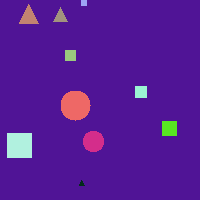

In [20]:
gen =  enumerate(my_test_data_loader)
(i, batch) = next(gen)
print(i)
torchvision.transforms.ToPILImage()(batch['image'][0])

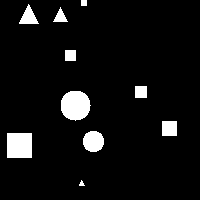

In [21]:
torchvision.transforms.ToPILImage()(batch['mask'][0])

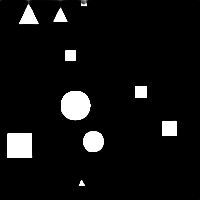

In [22]:
output = network(batch['image'].to(cuda))
torchvision.transforms.ToPILImage()(output[0].to(torch.device('cpu')))

1


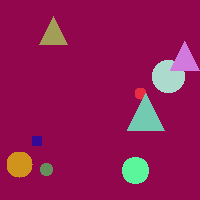

In [23]:
(i, batch) = next(gen)
print(i)
torchvision.transforms.ToPILImage()(batch['image'][0])

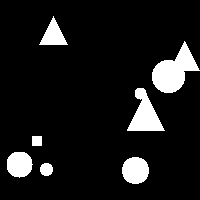

In [24]:
torchvision.transforms.ToPILImage()(batch['mask'][0])

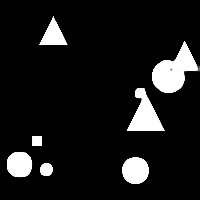

In [25]:
output = network(batch['image'].to(cuda))
torchvision.transforms.ToPILImage()(output[0].to(torch.device('cpu')))

2


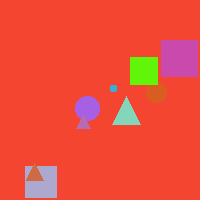

In [26]:
(i, batch) = next(gen)
print(i)
torchvision.transforms.ToPILImage()(batch['image'][0])

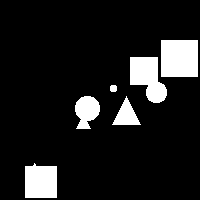

In [27]:
torchvision.transforms.ToPILImage()(batch['mask'][0])

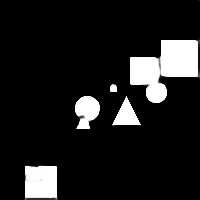

In [28]:
output = network(batch['image'].to(cuda))
torchvision.transforms.ToPILImage()(output[0].to(torch.device('cpu')))